In [1]:
from pymongo import MongoClient
from os import environ
import tiktoken
import pandas as pd
import seaborn as sns

from typing import List

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.globals import set_verbose

set_verbose(True)

In [2]:
client = MongoClient(environ["MONGODB_URI"])

In [3]:
MODEL = "gpt-3.5-turbo"

COST_PER_TOKEN = {
    "gpt-4": 30 / 10**6,
    "gpt-3.5-turbo": 0.5 / 10**6,
}

MAX_TOKENS = {
    "gpt-4": 32_768,
    "gpt-3.5-turbo": 16_385,
}

In [4]:
def count_tokens(text, model=MODEL):
    # https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
    encoding = tiktoken.encoding_for_model(model)
    return 3 + len(encoding.encode(text))

In [5]:
agg = [
    {
        "$match": {
            "text": {
                "$exists": True
            }
        }
    },
    {
        "$sample": {
            "size": 20
        }
    },
]

token_counts = []
for doc in client['juddges']['judgements'].aggregate(agg):
    num_tokens = count_tokens(doc['text'])
    token_counts.append({
        "_id": doc["_id"],
        "num_tokens": num_tokens
    })

token_counts_df = pd.DataFrame.from_records(token_counts)
token_counts_df

,_id,num_tokens
0,151020100002015_IV_P_000095_2017_Uz_2018-06-08...,2619
1,154505000001503_V_Ca_002798_2019_Uz_2020-07-30...,4382
2,152000000000503_I_ACa_001146_2016_Uz_2018-07-2...,13688
3,155500000001521_III_AUa_001190_2013_Uz_2014-07...,7138
4,152015250001006_II_K_000777_2018_Uz_2019-11-08...,15691
5,151515000005027_X_Ga_000122_2014_Uz_2014-06-13...,7371
6,154500000001006_II_AKa_000467_2018_Uz_2019-03-...,10251
7,153510000006003_XII_C_000691_2013_Uz_2015-11-0...,12086
8,151015000007503_XV_C_000004_2016_Uz_2016-11-23...,11763
9,154510050001006_II_K_001359_2018_Uz_2019-11-29...,878


In [6]:
estimated_cost = token_counts_df["num_tokens"].sum() * COST_PER_TOKEN[MODEL]

print(f"Estimated cost: ${estimated_cost:,.2f}")

Estimated cost: $0.08


<Axes: xlabel='num_tokens', ylabel='Count'>

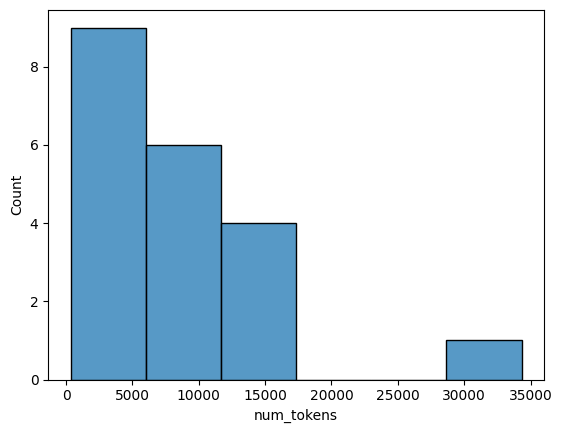

In [7]:
sns.histplot(
    data=token_counts_df,
    x="num_tokens",
)

In [8]:
INSTRUCTION = '''\
You are a question-answer generator. Your goal is to generate question-answer pairs given the Context.
Do not tranlate the Context, generate questions and answers in original language.

Context: {context}

Step 1: Identify spans that are likely to be answers to questions, identify as many as possible.
Step 2: For each identified span, generate a question.
Step 3: Respond to the question in only a few tokens concisely.

Ensure that you distinctly label and delineate Steps 1, 2 and 3.

{format_instructions}
'''

In [9]:
# Define your desired data structure.
class SyntheticLegisQAPairs(BaseModel):
    questions: List[str] = Field(description="List of generated questions")
    answers: List[str] = Field(description="List of generated answers")

In [10]:
output_parser = JsonOutputParser(pydantic_object=SyntheticLegisQAPairs)

In [11]:
print(output_parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"questions": {"title": "Questions", "description": "List of generated questions", "type": "array", "items": {"type": "string"}}, "answers": {"title": "Answers", "description": "List of generated answers", "type": "array", "items": {"type": "string"}}}, "required": ["questions", "answers"]}
```


In [12]:
prompt = ChatPromptTemplate.from_template(
    template=INSTRUCTION,
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
)

In [13]:
model = ChatOpenAI(model=MODEL)

chain = prompt | model | output_parser

for doc in client['juddges']['judgements'].aggregate(agg):
    num_tokens = count_tokens(doc['text'])
    if num_tokens > 0.95 * MAX_TOKENS[MODEL]:
        print(f"Skipping document with _id: {doc['_id']}, too many tokens ({num_tokens:,}; max: {MAX_TOKENS[MODEL]:,})")
        continue

    qa_pairs = chain.invoke({"context": doc["text"]})
    qa_pairs_str_fmt = "\n\n".join(f"\tQuestion: {q}\n\tAnswer: {a}" for q, a in zip(qa_pairs["questions"], qa_pairs["answers"]))
    print(f"Content: {doc['text'][:1_000]}\n{' ... '.center(80)}")
    print(f"\n\nGenerated QA pairs:\n\n{qa_pairs_str_fmt}")
    print("\n\n", "=" * 100, "\n\n")

Content: Rybnik, 30 stycznia 2020 r.
Sygn. akt V  Ka 756/19

WYROK
W IMIENIU RZECZYPOSPOLITEJ POLSKIEJ

    Sąd Okręgowy w Gliwicach Ośrodek Zamiejscowy w Rybniku

Wydział V Karny
w składzie:
Przewodniczący:Jacek Myśliwiec (spr.)
Sędziowie:Sławomir Klekocki
Lucyna Pradelska-Staniczek
Protokolant:  Beata Pinior
w obecności oskarżyciela Jacka Trelenberga Prokuratora Prokuratury Rejonowej wR.
po rozpoznaniu w dniu 30 stycznia 2020r.
sprawy:M. C./C./

s.M.iL.

ur. (...)wG.

oskarżonego o czyny zart. 280 § 1 kkiart. 157 § 1 kkw z.w zart. 11 § 2 kkiart. 64 § 1 kk

W.K.

c.M.iE.

ur.(...)wK.

oskarżonej o czyn zart. 280 § 1 kk, art 62 ust. 1 Ustawy o przeciwdziałaniu narkomanii
na skutek apelacji wniesionych przez obrońców oskarżonych
od wyroku Sądu Rejonowego w Rybniku Wydziału III Karnego
z dnia 17 września 2019r. sygn. akt III K 817/18
I.utrzymuje w mocy zaskarżony wyrok;
II. zasądza od Skarbu Państwa na rzecz adw.P. M.kwotę 420 (czterysta dwadzieścia) złotych oraz 23% podatku VAT w kwocie